In [1]:
# The trust-region Newton method applied to LJ7 cluster in 3D 

import numpy as np
import scipy
import matplotlib.pyplot as plt
from LJhelpers import *

In [2]:
# Set up the initial configuration

# Four lical minima of LJ7:
# f1 = -16.50538417 Pentagonal bipyramid 
# f2 = -15.93504306 Capped octahedron 
# f3 = -15.59321094 Tricapped tetrahedron 
# f4 = -15.53306005 Bicapped trigonal bipyramid

# Options: model = 0,1,2,3, or 4.
# Model 0 corresponds to a random initialization.
# Models 1--4 set the system up close to the corresponding local minima
# listed above.


In [3]:
Na = 7 #the number of atoms
rstar = 2**(1/6) # argument of the minimum of the Lennard-Jones pair potential V(r) = r^(-12) - r^(-6)
tol = 1e-6 # stop iterations when ||grad f|| < tol
iter_max = 200 # the maximal number of iterations
draw_flag = 1 # if draw_flag = 1, draw configuration at every iteration
# parameters for trust region
Delta_max = 5 # the max trust-region radius
Delta_min = 1e-12 # the minimal trust-region radius
Delta = 1 # the initial radius
eta = 0.1 # step rejection parameter
subproblem_iter_max = 5 # the max # of iteration for quadratic subproblems
tol_sub = 1e-1 # relative tolerance for the subproblem
rho_good = 0.75 # if rho > rho_good, increase the trust-region radius
rho_bad = 0.25 # if rho < rho_bad, decrease the trust-region radius

def cauchy_point(B,g,Delta):
    ng = np.linalg.norm(g)
    ps = -g*Delta/ng
    aux = np.dot(g,B @ g)
    if( aux <= 0 ):
        p = ps
    else:
        a = np.minimum(ng**3/(Delta*aux),1)
        p = ps*a
    return p

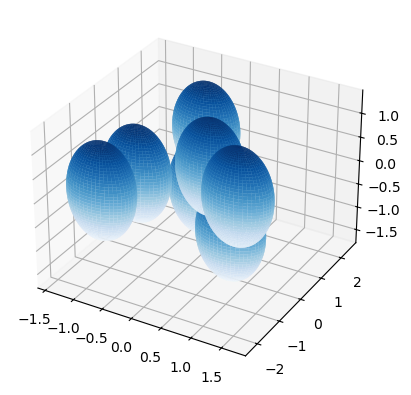

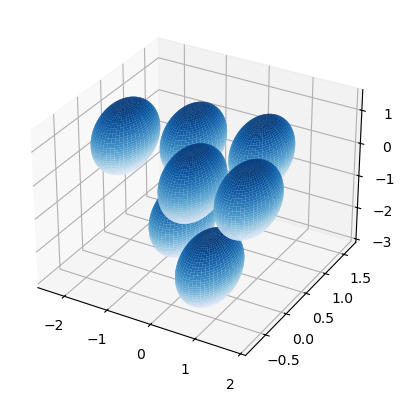

LJpot =  -6.743721603062471


In [4]:
# select the initial configuration
model = 0
if( model > 0):
    Na = 7
xyz = initial_configuration(model,Na,rstar)
drawconf(xyz,0.5*rstar);

x = remove_rotations_translations(xyz)
drawconf(LJvector2array(x),0.5*rstar)
print("LJpot = ",LJpot(x))

In [5]:
# initialization
f = LJpot(x)
g = LJgrad(x)
norm_g = np.linalg.norm(g)
print("Initially, f = ",f,", ||grad f|| = ",norm_g)

fvals = np.zeros(iter_max)
fvals[0] = f
ngvals = np.zeros(iter_max)
ngvals[0] = norm_g
Delta = 1 # the initial trust region radius
I = np.eye(np.size(x),dtype = float)

iter = 1

Initially, f =  -6.743721603062471 , ||grad f|| =  8.672750035603244


Reject: iter 1: f = -6.7437216031, |df| = 8.6728e+00, rho = -9.5693e+02, Delta = 2.5000e-01, j_sub = 3
Accept: iter 2: f = -8.6013055249, |df| = 5.1392e+00, rho = 8.1798e-01, Delta = 5.0000e-01, j_sub = 3
Accept: iter 3: f = -9.9345703986, |df| = 1.4714e+01, rho = 6.9016e-01, Delta = 5.0000e-01, j_sub = 3
Accept: iter 4: f = -10.8499382761, |df| = 1.7543e+01, rho = 4.0289e-01, Delta = 5.0000e-01, j_sub = 2
Reject: iter 5: f = -10.8499382761, |df| = 1.7543e+01, rho = -1.9421e-01, Delta = 1.2500e-01, j_sub = 2
Accept: iter 6: f = -11.7427786183, |df| = 5.8096e+00, rho = 9.4274e-01, Delta = 2.5000e-01, j_sub = 3
Accept: iter 7: f = -12.7395591997, |df| = 4.3176e+00, rho = 9.0044e-01, Delta = 5.0000e-01, j_sub = 3
Reject: iter 8: f = -12.7395591997, |df| = 4.3176e+00, rho = -8.4788e+00, Delta = 1.2500e-01, j_sub = 2
Accept: iter 9: f = -13.3479798542, |df| = 5.3728e+00, rho = 9.9799e-01, Delta = 2.5000e-01, j_sub = 2
Reject: iter 10: f = -13.3479798542, |df| = 5.3728e+00, rho = -5.0941e-01

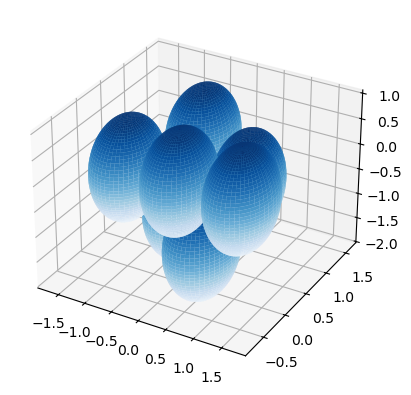

In [6]:
# the main trust-region cycle
while (norm_g > tol and iter < iter_max):      
    # solve the constrained minimization problem 
    B = LJhess(x)
    flag_boundary = 0 
    # check if B is SPD
    eval_min = np.amin(np.real(scipy.linalg.eig(B, b=None, left=False, right=False)))
    j_sub = 0
    if( eval_min > 0 ): # B is SPD: B = R'*R, R'*R*p = -g 
        p = scipy.linalg.solve(B,-g)
        p_norm = np.linalg.norm(p)
        if( p_norm > Delta ): # else: we are done with solbing the subproblem
            flag_boundary = 1        
    else:
        flag_boundary = 1
    if( flag_boundary == 1 ): # solution lies on the boundary
        lam_min = np.maximum(-eval_min,0.0)
        lam = lam_min + 1
        R = scipy.linalg.cholesky(B+lam*I,lower = False)
        flag_subproblem_success = 0;
        while( j_sub < subproblem_iter_max ):
            j_sub = j_sub + 1;
            p = scipy.linalg.solve_triangular(np.transpose(R),-g,lower = True)
            p = scipy.linalg.solve_triangular(R,p,lower = False)
            p_norm = np.linalg.norm(p)
            dd = np.absolute(p_norm - Delta)
            if( dd < tol_sub*Delta ):
                flag_subproblem_success = 1
                break
            q = scipy.linalg.solve_triangular(np.transpose(R),p,lower = True)
            q_norm = np.linalg.norm(q);
            dlam = ((p_norm/q_norm)**2)*(p_norm - Delta)/Delta
            lam_new = lam + dlam;
            if (lam_new > lam_min):
                lam = lam_new
            else:
                lam = 0.5*(lam + lam_min)
            R = scipy.linalg.cholesky(B+lam*I,lower = False)
        if( flag_subproblem_success == 0 ):
            p = cauchy_point(B,g,Delta)
    # assess the progress
    xnew = x + p
    fnew = LJpot(xnew)
    gnew = LJgrad(xnew)
    mnew = f + np.dot(g,p) + 0.5*np.dot(p,B @ p)
    rho = (f - fnew)/(f - mnew+1e-14)
    # adjust the trust region
    if( rho < rho_bad ):
        Delta = np.maximum(0.25*Delta,Delta_min)
    else:
        if(  rho > rho_good and flag_boundary == 1 ):
            Delta = np.minimum(Delta_max,2*Delta)
    # accept or reject step
    if( rho > eta ):  # accept step          
        x = xnew
        f = fnew
        g = gnew
        norm_g = np.linalg.norm(g)
        print(f'Accept: iter {iter}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}')
    else:
        print(f'Reject: iter {iter}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}')
    if( iter % 20 == 19 ):
        # restore all coordinates
        xyz = LJvector2array(x)
        drawconf(xyz,0.5*rstar)
    fvals[iter] = f
    ngvals[iter] = norm_g
    iter = iter + 1




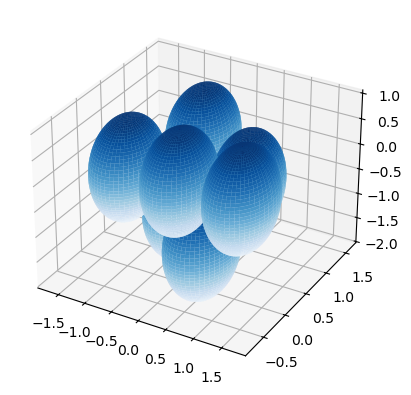

In [7]:
# visualize the final configuration and plot graphs
xyz = LJvector2array(x)    
drawconf(xyz,0.5*rstar)

Text(0, 0.5, 'Function values')

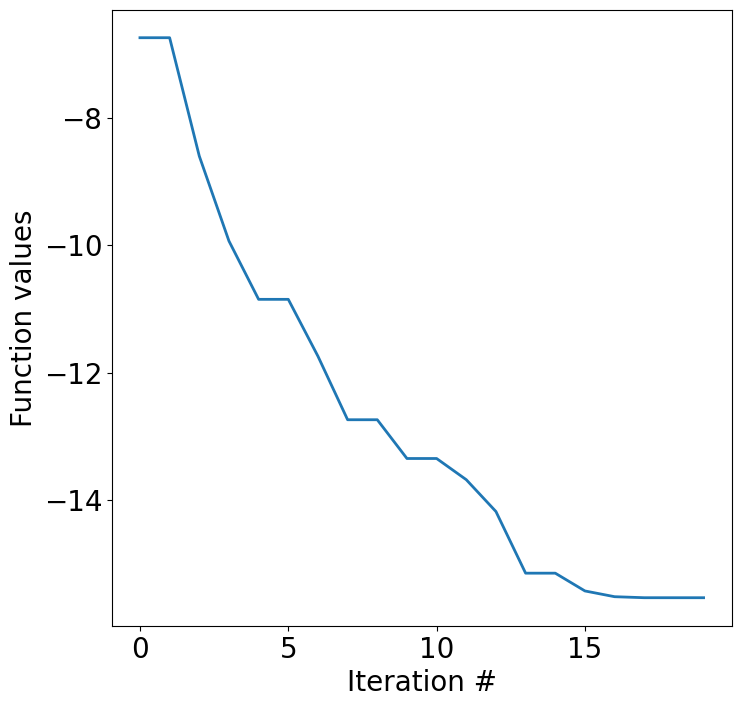

In [8]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,8))
plt.plot(np.arange(iter),fvals[0:iter],linewidth = 2)
plt.xlabel("Iteration #")
plt.ylabel("Function values")

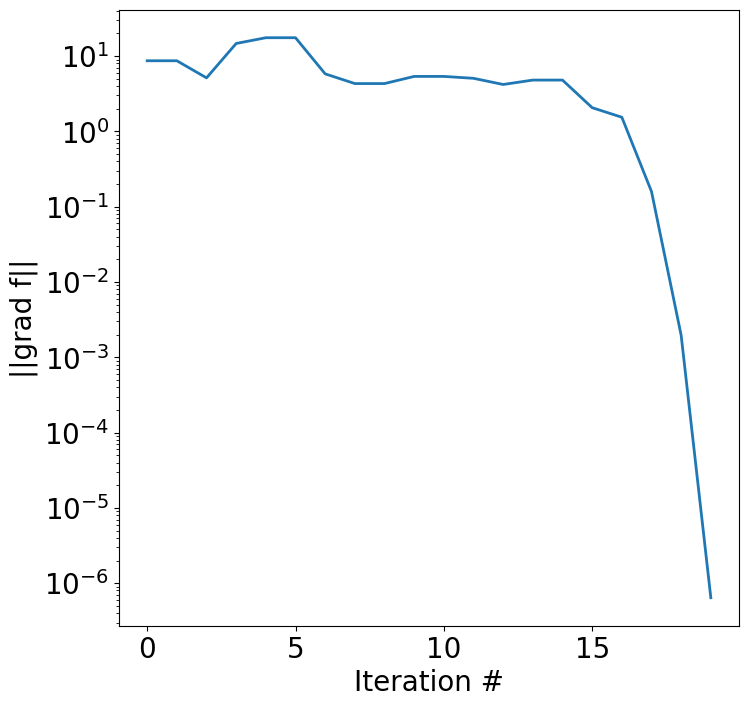

In [9]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,8))
plt.plot(np.arange(iter),ngvals[0:iter],linewidth = 2)
plt.xlabel("Iteration #")
plt.ylabel("||grad f||")
plt.yscale("log")

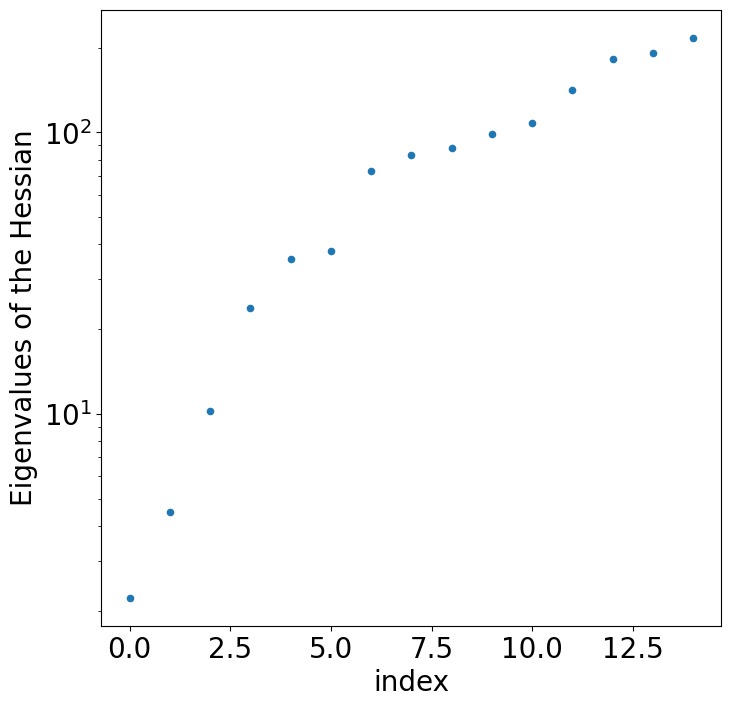

In [10]:
plt.rcParams.update({'font.size': 20})
H = LJhess(x)
evals = np.sort(np.linalg.eigvals(H))
plt.figure(figsize=(8,8))
plt.scatter(np.arange(np.size(x)),evals,s = 20)
plt.xlabel("index")
plt.ylabel("Eigenvalues of the Hessian")
if( evals[0] > 0 ):
    plt.yscale("log")
